In [1]:
%run flow_tools.py

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['/Users/weinberz/Library/CloudStorage/Box-Box/SynCellMotifs/Flow/20220628_SynTF_SS564OHT_SS57ABA/',
          '/Users/weinberz/Library/CloudStorage/Box-Box/SynCellMotifs/Flow/20220628_SynTF_SS58GZV/']

In [4]:
df = pd.concat([load_data(folder, colnames = ['WellName', 'Cells', 'Drug', 'Dose', 'Replicate', 'Plate']) 
                for folder in folders], ignore_index=True)

In [5]:
#remove NAs
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (1e5, 8e4),
              (4e4, 2e4),
              (4e4, 1e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.7e5),
              (1.25e5, 9e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

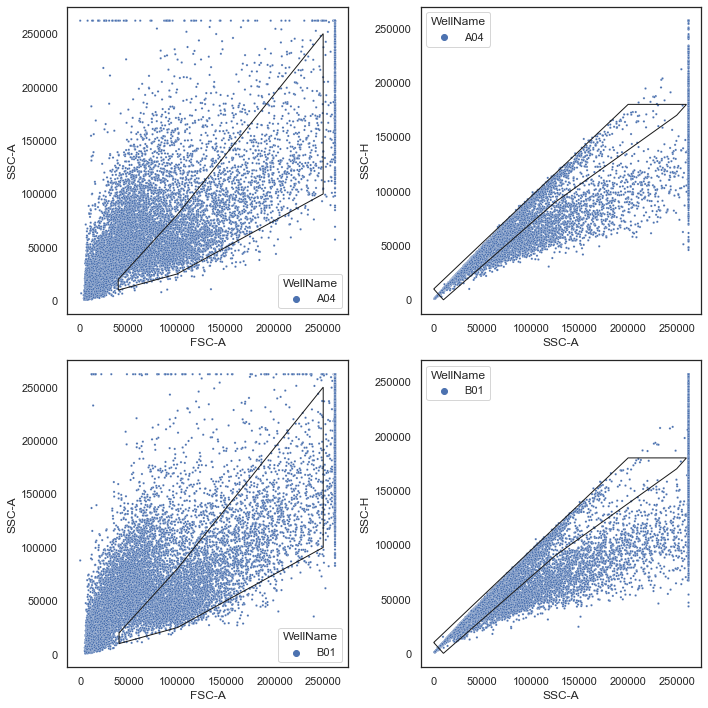

In [8]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A04']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A04'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

Text(0.5, 22.959999999999972, 'log <channel>')

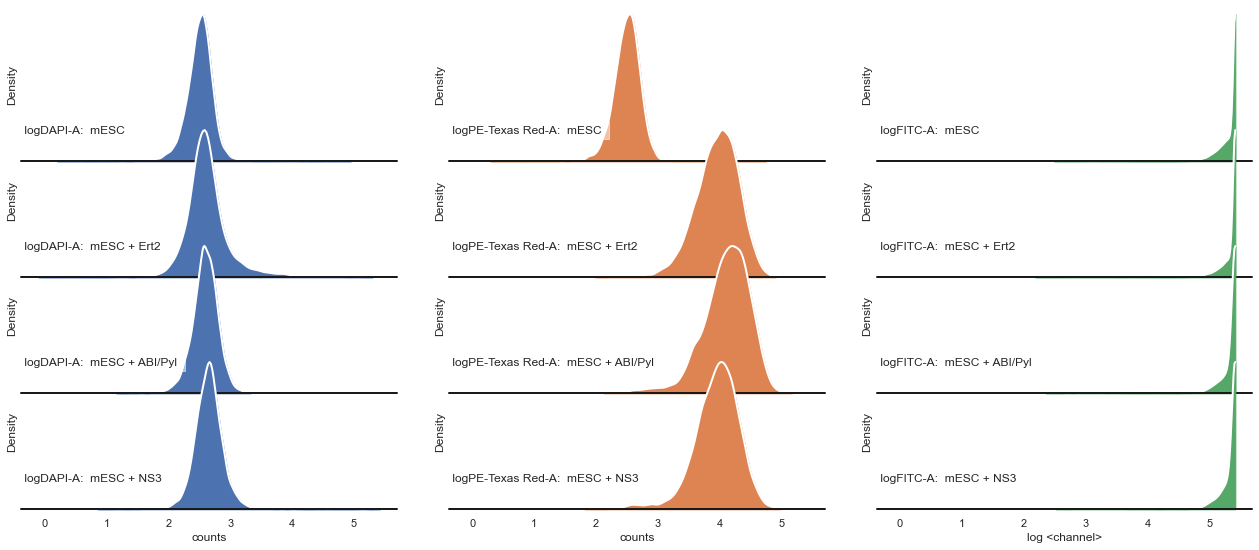

In [10]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A'], 
                       id_vars=['index','WellName','Cells','Dose'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[simplified_df["Dose"].isin(['Untreated'])], 
                  row = 'Cells', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

Text(0.5, 22.959999999999972, 'TF Expression (logRFP)')

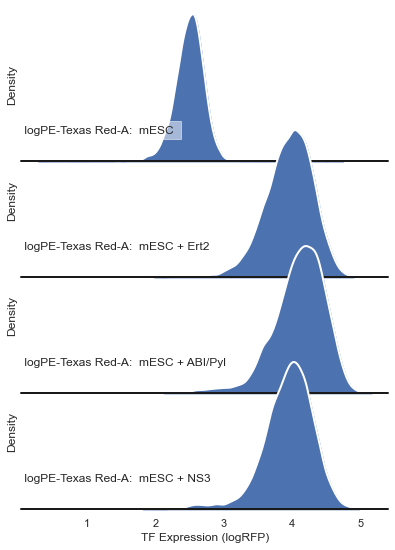

In [11]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A'], 
                       id_vars=['index','WellName','Cells','Dose'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[simplified_df["Dose"].isin(['Untreated']) &
                                     simplified_df['channel'].isin(['logPE-Texas Red-A'])], 
                  row = 'Cells', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("TF Expression (logRFP)")

In [8]:
df2 = df2[df2['logFITC-A']>4]
# df2 = df2[((df2['Cells'].isin(['mESC + Ert2','mESC + ABI/Pyl','mESC + NS3']) & (df2['logPE-Texas Red-A'] > 2)) |
#            ((df2['Cells']=='mESC') & (df2['logPE-Texas Red-A'] < 2.5)))]

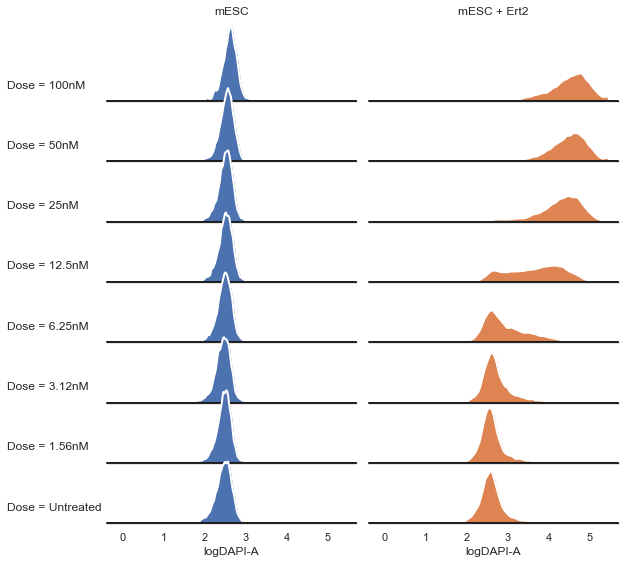

In [13]:
cell_order = ['mESC', 'mESC + Ert2']
drug_of_interest = '4OHT'

g = sns.FacetGrid(data=df2[df2['Drug']==drug_of_interest], row='Dose', col='Cells', hue='Cells', 
                  col_order=cell_order, hue_order=cell_order, height=1, aspect=4)
g.map(sns.kdeplot, "logDAPI-A", shade=True, alpha=1, bw_adjust=.5, clip=None, cut=0)
g.map(sns.kdeplot, "logDAPI-A", color="w", lw=2, bw_adjust=.5, clip=None, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)


for ax in g.axes.flat:
    ax.set(facecolor=(0, 0, 0, 0))
    
for ax in g.axes[:,0]:
    wellname = ax.get_title().split('|')[0]
    ax.text(-0.4,0.2, "{}".format(wellname), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

g.set_titles("")

for ax, cells in zip(g.axes[0,:], cell_order):
    ax.set_title(cells)
    
g.set(yticks=[])
g.set_ylabels('')
g.despine(bottom=False, left=True)
#plt.savefig('figure_4OHT_dose_kdeplot.eps', bbox_inches='tight')

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


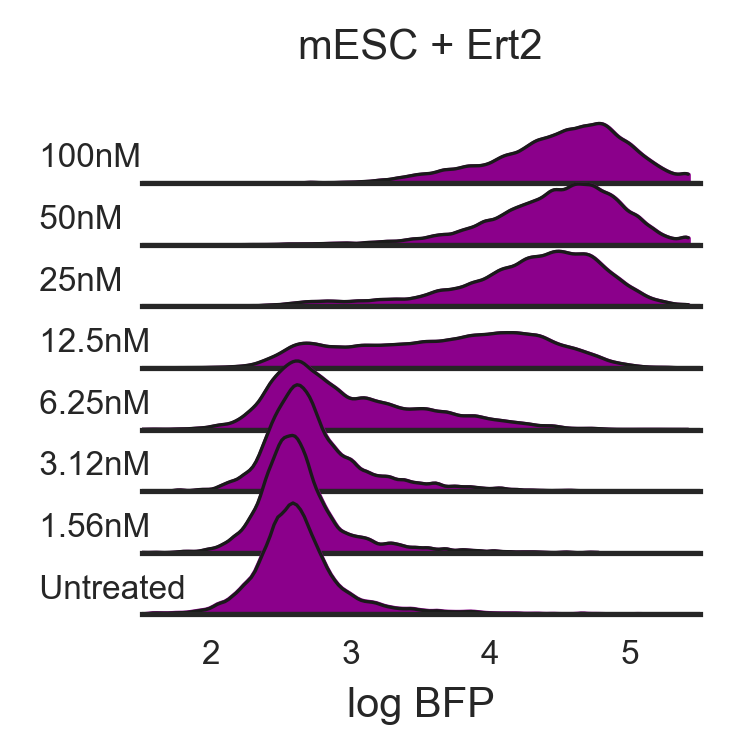

In [25]:
cell_order = ['mESC + Ert2']
drug_of_interest = '4OHT'

with sns.color_palette(['darkmagenta']):
    g = sns.FacetGrid(data=df2[df2['Drug']==drug_of_interest], row='Dose', col='Cells', hue='Cells', 
                  col_order=cell_order, hue_order=cell_order, height=0.3, aspect=8, xlim=[1.5, 5.5])
g.map(sns.kdeplot, "logDAPI-A", fill=True, alpha=1, bw_adjust=.5, clip=None, cut=0)
g.map(sns.kdeplot, "logDAPI-A", color="k", lw=.8, bw_adjust=.5, clip=None, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)


# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)
g.tick_params('x',labelsize=SMALL_SIZE)


for ax in g.axes.flat:
    ax.set(facecolor=(0, 0, 0, 0))
    
for ax in g.axes[:,0]:
    wellname = ax.get_title().split('=')[1].split('|')[0]
    ax.text(-0.2,0.2, "{}".format(wellname), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0), transform=ax.transAxes, fontsize=SMALL_SIZE)

g.set_titles("")

for ax, cells in zip(g.axes[0,:], cell_order):
    ax.set_title(cells, y=0.8, fontsize=MEDIUM_SIZE)
    
g.set(yticks=[])
g.set_xlabels("log BFP")
g.set_ylabels('')
g.despine(bottom=False, left=True)

g.fig.set_dpi(300)
plt.savefig(outputdir + 'figure_4OHT_dose_kdeplot_manu.pdf', bbox_inches='tight', dpi=300)

In [10]:
summary_df = (df2[df2['Drug']=='4OHT']
 .groupby(['Drug','Cells','Dose','Replicate'])['logDAPI-A'].agg(np.median)
 .reset_index())

summary_df = summary_df.replace(['Untreated', '1.56nM', '3.12nM', '6.25nM', '12.5nM', '25nM', '50nM', '100nM'],[0, 1.56E-9, 3.12E-9, 6.25E-9, 12.5E-9, 25E-9, 50E-9, 100E-9])

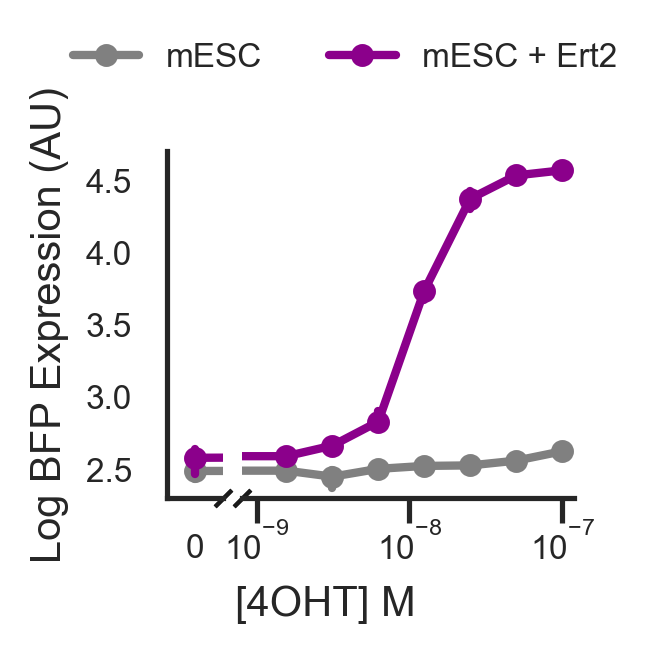

In [28]:
with sns.color_palette(['gray','darkmagenta']):
    fig, (left_ax, right_ax) = plt.subplots(1,2,sharey=True,figsize=(1.75,1.5), gridspec_kw={'width_ratios': [1,6]})
    g=sns.pointplot(data=summary_df, x='Dose',y='logDAPI-A', hue='Cells', estimator=np.mean, ax=left_ax, native_scale=True, markersize=4, linewidth=2)
    g=sns.pointplot(data=summary_df, x='Dose',y='logDAPI-A', hue='Cells', estimator=np.mean, ax=right_ax, native_scale=True, markersize=4, linewidth=2)
    left_ax.set_ylabel('Log BFP Expression (AU)')
    left_ax.legend().remove()
    left_ax.tick_params(axis='both',labelsize=SMALL_SIZE, pad=2.5)
    left_ax.set_ylim(2.3, 4.7)
    left_ax.set_xlim(-1e-10, 1e-10)
    left_ax.set_xticks([0])
    left_ax.set_xlabel('')
    left_ax.ticklabel_format(axis='x',style='sci', scilimits=(0,0))
    
    right_ax.legend(frameon=False, loc='upper left', bbox_to_anchor=[-0.6, 1.4], ncols=2)
    right_ax.tick_params(axis='both',labelsize=SMALL_SIZE)
    right_ax.set_xscale('log')
    right_ax.set_xlim(8e-10, 1.2e-7)
    right_ax.tick_params(axis='x', which='both', bottom=True)
    right_ax.set_xticks([1e-9, 1e-8, 1e-8], minor=True)
    right_ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    right_ax.set_xlabel('[4OHT] M')
    # get rid of the lines on the outer edge
    sns.despine()
    right_ax.spines.left.set_visible(False)
    right_ax.xaxis.set_label_coords(.25, -0.25)
    plt.subplots_adjust(wspace=0.1)
    d = .1  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-d, -d), (d, d)], markersize=4,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    left_ax.plot([1, 1], [0, 0], transform=left_ax.transAxes, **kwargs)
    right_ax.plot([0, 0], [0, 0], transform=right_ax.transAxes, **kwargs)
    fig.set_dpi(300)

plt.savefig(outputdir + 'figure_4OHT_pointplot_talk.pdf', bbox_inches='tight')